In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from itertools import product                    
from tqdm import tqdm_notebook
import datetime as dt
import urllib.request, json 
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [2]:
xle = pd.read_csv("stock_data/xle_data2.csv")
xle.head()

,Date,High,Low,Open,XLE,Volume,Adj Close,DlyRtn
0,1/4/1999,23.750000,23.281250,23.28125,23.328119,28600,15.657917,NaN
1,1/5/1999,23.468750,23.171881,23.46875,23.203119,42700,15.574017,-0.535834
2,1/6/1999,24.000000,23.312500,23.46875,23.968750,56400,16.087919,3.299744
3,1/7/1999,23.984381,23.578119,23.96875,23.859381,72600,16.014498,-0.456376
4,1/8/1999,24.562500,23.375000,24.00000,23.968750,421100,16.087919,0.458469


In [3]:
xle = xle.iloc[124:] #setting the data to range from 7/1/1999 to 7/1/2019

In [4]:
def set_index(df):
    """This function sets the Date to the index, drops the Date column
    and converts the index to datetime format"""
    df.set_index(df['Date'], inplace=True)
    df.drop(['Date'], axis=1, inplace=True)
    pd.to_datetime(df.index)

In [5]:
set_index(xle)
xle.head()

,High,Low,Open,XLE,Volume,Adj Close,DlyRtn
Date,,,,,,,
7/1/1999,28.312500,27.968750,28.12500,28.265619,33200,19.136637,0.779893
7/2/1999,28.453119,28.093750,28.28125,28.359381,51600,19.200111,0.331692
7/6/1999,29.109381,28.500000,28.50000,28.890619,48800,19.559778,1.873254
7/7/1999,28.843750,28.593750,28.84375,28.812500,120600,19.506897,-0.270357
7/8/1999,29.218750,28.953119,29.00000,29.000000,94300,19.633835,0.650733


In [7]:
data = xle

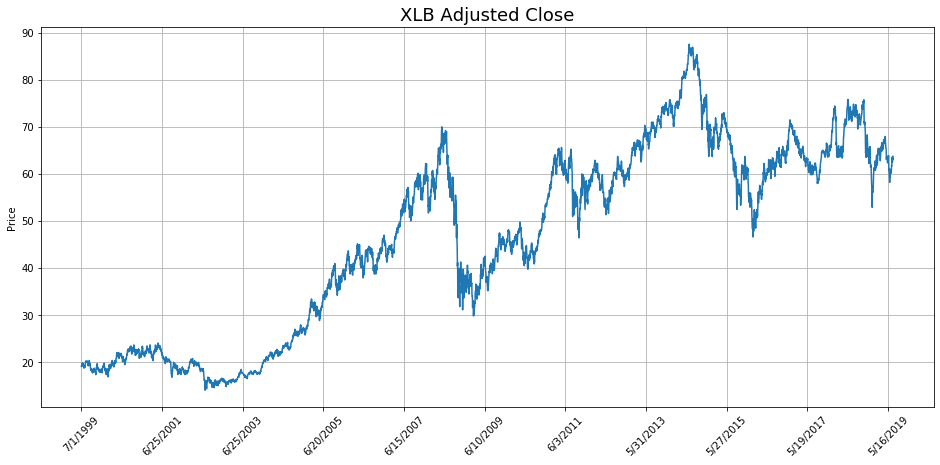

In [8]:
def close_plot(df, column, title):    
    plt.figure(figsize=(16,7))
    plt.xticks(range(0,df.shape[0],500),df.index[::500],rotation=45)
    plt.plot(df[column])
    plt.grid(True)
    plt.ylabel('Price')
    plt.title(title, fontsize=18)
    plt.show()
close_plot(data, 'Adj Close',  'XLB Adjusted Close')

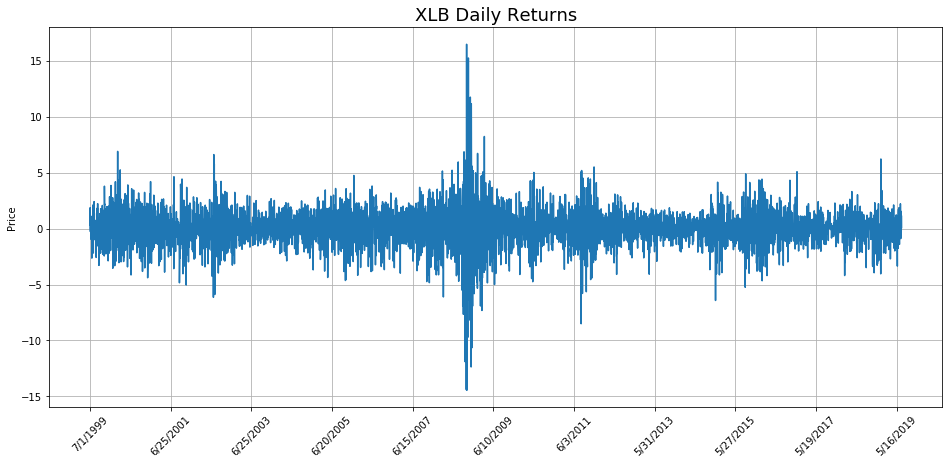

In [9]:
def return_plot(df, column, title):    
    plt.figure(figsize=(16,7))
    plt.xticks(range(0,df.shape[0],500),df.index[::500],rotation=45)
    plt.ylabel('Returns(%)')
    plt.plot(df[column])
    plt.grid(True)
    plt.title(title, fontsize=18)
    plt.show()
close_plot(data, 'DlyRtn',  'XLB Daily Returns')

In [10]:
data.iloc[4907]  #first trading day of 2018

High         5.887000e+01
Low          5.615000e+01
Open         5.644000e+01
XLE          5.848000e+01
Volume       2.489260e+07
Adj Close    5.750006e+01
DlyRtn       1.970365e+00
Name: 1/2/2019, dtype: float64

In [11]:
data.iloc[4907] #first trading day of 2019

High         5.887000e+01
Low          5.615000e+01
Open         5.644000e+01
XLE          5.848000e+01
Volume       2.489260e+07
Adj Close    5.750006e+01
DlyRtn       1.970365e+00
Name: 1/2/2019, dtype: float64

In [12]:
# def mid_price(df):   
#     high_prices = df.loc[:,'High'].as_matrix()
#     low_prices = df.loc[:,'Low'].as_matrix()
#     mid_prices = (high_prices+low_prices)/2.0
#     return mid_prices

In [13]:
train_data = data.DlyRtn[:4907].as_matrix()
test_data = data.DlyRtn[4907:].as_matrix()

In [14]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [15]:
smoothing_window_size = 900
for di in range(0,4500,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])


In [16]:
#normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [17]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

In [18]:
# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [19]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(4907):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA


In [20]:
# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

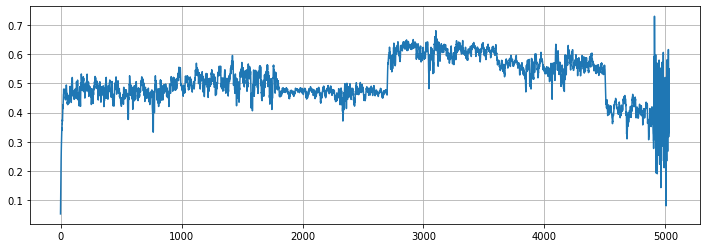

In [21]:
plt.figure(figsize=(12,4))
plt.plot(all_mid_data)
plt.grid(True)
plt.show()

In [22]:
window_size = 50
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00035


In [23]:
window_size = 50
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    #run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00009


In [24]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.05306545 0.53644556 0.46993482 0.6083004  0.5513285 ]

	Output: [0.21335538 0.5417215  0.47335273 0.5970292  0.5785976 ]


Unrolled index 1
	Inputs:  [0.09738748 0.5221264  0.4756079  0.5821822  0.5785976 ]

	Output: [0.23869203 0.5221264  0.47335273 0.58659977 0.5785976 ]


Unrolled index 2
	Inputs:  [0.14909826 0.53700864 0.47512177 0.5970292  0.6003421 ]

	Output: [0.21335538 0.5417215  0.47512177 0.58659977 0.58179754]


Unrolled index 3
	Inputs:  [0.1792004  0.53836614 0.47335273 0.6019159  0.58179754]

	Output: [0.1792004  0.53836614 0.47644123 0.60671383 0.5866089 ]


Unrolled index 4
	Inputs:  [0.21335538 0.5417215  0.4787931  0.5970332  0.59193087]

	Output: [0.2697618  0.5417215  0.47167996 0.60671383 0.59193087]


### Defining Hyperparameters 

In [25]:
D = 1 # Dimensionality of the data
num_unrollings = 50 # Number of time steps looking into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [250,200,100] # Number of hidden nodes in each layer of the deep LSTM stack
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() #important for running this multiple times

In [26]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))


In [27]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

In [28]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
    c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
    initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

In [29]:

print('Defining Training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
    for ui in range(num_unrollings):
        loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning Rate Decay Operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining Training Loss
Learning Rate Decay Operations
TF Optimization operations
	All done


In [30]:
print('Defining Prediction Related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
    sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
    initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
    sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining Prediction Related TF functions
	All done


In [31]:
epochs = 30
valid_summary = 1 # Interval to make test predictions

n_predict_once = 25 # Number of steps to continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points to start test predictions from
test_points_seq = np.arange(4907,5032,25).tolist()

for ep in range(epochs):       

    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

        average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

      # The average loss
        if (ep+1)%valid_summary==0:
            print('Average loss at step %d: %f' % (ep+1, average_loss))

        train_mse_ot.append(average_loss)

        average_loss = 0 # reset loss

        predictions_seq = []

        mse_test_loss_seq = []

      # ===================== Updating State and Making Predicitons ========================
        for w_i in test_points_seq:
            mse_test_loss = 0.0
            our_predictions = []

            if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
                x_axis=[]

        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
            for tr_i in range(w_i-num_unrollings+1,w_i-1):
                current_price = all_mid_data[tr_i]
                feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
                _ = session.run(sample_prediction,feed_dict=feed_dict)

            feed_dict = {}

            current_price = all_mid_data[w_i-1]

            feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

            # Make predictions for this many steps
            # Each prediction uses previous prediciton as it's current input
            for pred_i in range(n_predict_once):

                pred = session.run(sample_prediction,feed_dict=feed_dict)

                our_predictions.append(np.asscalar(pred))

                feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

                if (ep+1)-valid_summary==0:
                    # Only calculate x_axis values in the first validation epoch
                    x_axis.append(w_i+pred_i)

                mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

            session.run(reset_sample_states)

            predictions_seq.append(np.array(our_predictions))

            mse_test_loss /= n_predict_once
            mse_test_loss_seq.append(mse_test_loss)

            if (ep+1)-valid_summary==0:
                x_axis_seq.append(x_axis)

        current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
        if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
            loss_nondecrease_count += 1
        else:
            loss_nondecrease_count = 0

        if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

        test_mse_ot.append(current_test_mse)
        print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
        predictions_over_time.append(predictions_seq)
        print('\tFinished Predictions')

Initialized
Average loss at step 1: 5.205843
	Test MSE: 0.03251
	Finished Predictions
Average loss at step 2: 0.678934
	Test MSE: 0.01594
	Finished Predictions
Average loss at step 3: 0.236763
	Test MSE: 0.00889
	Finished Predictions
Average loss at step 4: 0.126562
	Test MSE: 0.00679
	Finished Predictions
Average loss at step 5: 0.092415
	Test MSE: 0.00758
	Finished Predictions
Average loss at step 6: 0.085515
	Test MSE: 0.00683
	Finished Predictions
Average loss at step 7: 0.075994
	Decreasing learning rate by 0.5
	Test MSE: 0.00688
	Finished Predictions
Average loss at step 8: 0.068930
	Test MSE: 0.00684
	Finished Predictions
Average loss at step 9: 0.065992
	Test MSE: 0.00681
	Finished Predictions
Average loss at step 10: 0.064806
	Decreasing learning rate by 0.5
	Test MSE: 0.00682
	Finished Predictions
Average loss at step 11: 0.062894
	Test MSE: 0.00682
	Finished Predictions
Average loss at step 12: 0.062160
	Test MSE: 0.00682
	Finished Predictions
Average loss at step 13: 0.0627

In [32]:
round(min(test_mse_ot), 5) #Lowest test MSE

0.00679

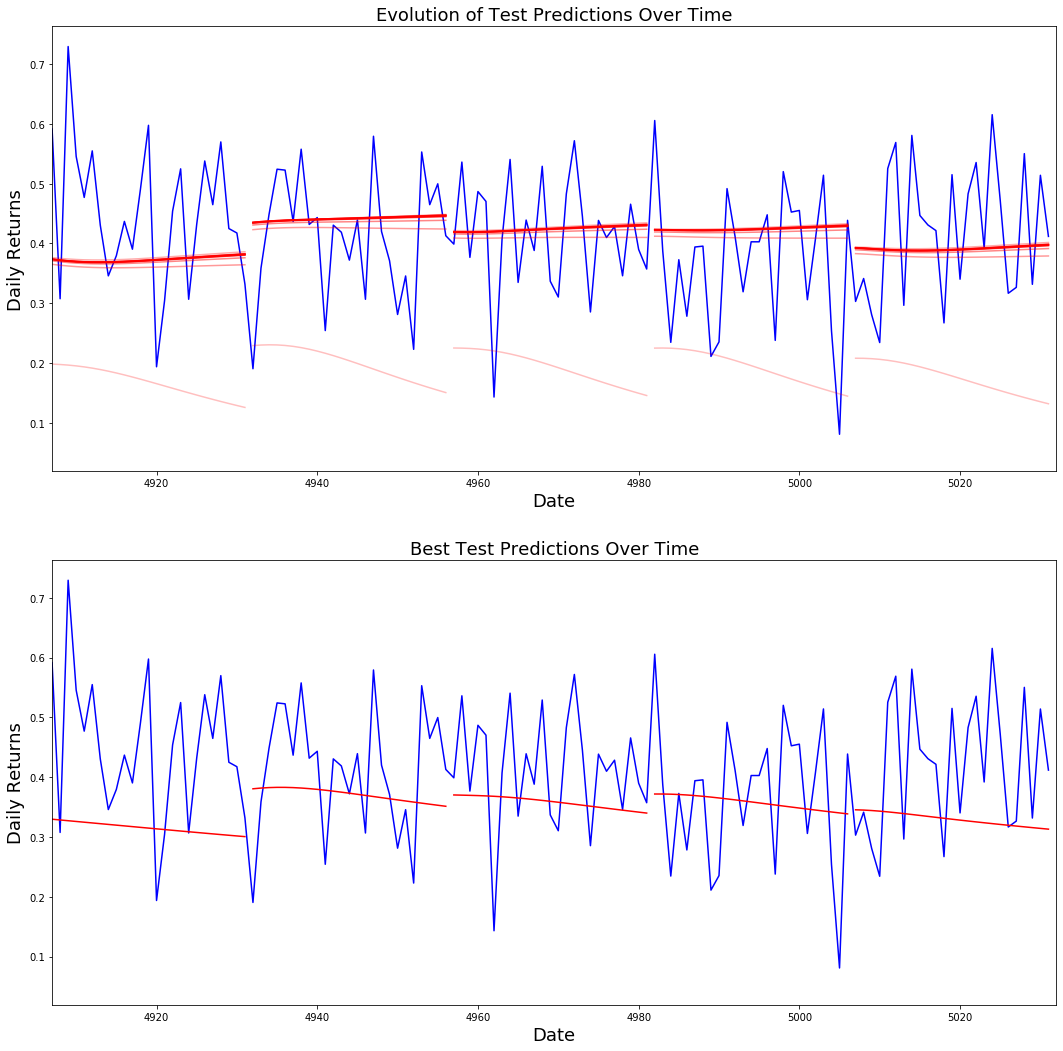

In [33]:
best_prediction_epoch = 2
plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(data.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Daily Returns',fontsize=18)
plt.xlim(4907,5032)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(data.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Daily Returns',fontsize=18)

plt.xlim(4907,5032)
plt.show() 

In [34]:
array = predictions_over_time[best_prediction_epoch] #arrays of scaled predictions

In [35]:
def pred_df(arraylist, test_data):
    """combines scaled prediction data and test data 
    into one one dataframe"""
    array = [x for y in arraylist for x in y]
    testdata = list(test_data)
    pred = pd.DataFrame(testdata, array)
    pred.reset_index(inplace=True)
    pred.rename(index=str, columns={ 'index': 'test_data', 0: 'predictions' }, inplace=True)
    return pred 

In [36]:
pred = pred_df(array, test_data)

In [37]:
def unscaled_pred_df(df, df_pred):
    """Unscales data and returns a preliminary graph comparing 
    predictions to test data"""
    
    train_data_new = df.DlyRtn[:4907].as_matrix()
    test_data_new = df.DlyRtn[4907:].as_matrix()


    for i in range(0, df_pred.shape[0], 4):
        scaler.fit(np.append(train_data_new[-500+i:], test_data_new[i-4:i], axis=0).reshape(-1, 1))
        df_pred.loc[i:i+4, 'Predictions'] = scaler.inverse_transform(df_pred.predictions[i:i+4].values.reshape(-1,1)).reshape(-1,)

    df_pred['Unscaled_Test']  = test_data_new
    df_pred = df_pred.drop(['test_data', 'predictions'], axis=1)
    
    return df_pred.plot(figsize=(14, 4))

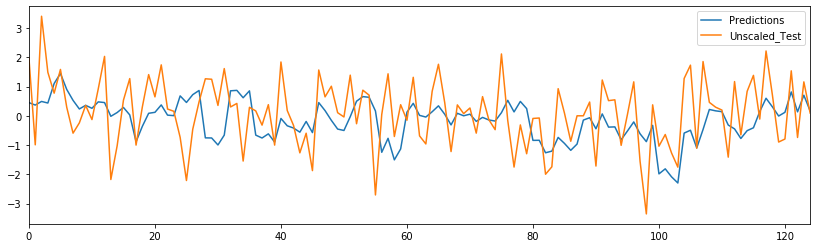

In [38]:
unscaled_pred_df(data, pred);

In [39]:
def prediction_df(etf, pred_data):    
    new_etf = etf.iloc[4907:] 
    new_etf.reset_index(inplace=True)
    pred_data.reset_index(inplace=True)
    dataframe = pd.concat([new_etf, pred_data], axis=1)
    dataframe2 = dataframe[['Date', 'DlyRtn', 'Predictions']]
    set_index(dataframe2)
    
    return dataframe2

In [40]:
xle_pred = prediction_df(data, pred)
xle_pred.head()

,DlyRtn,Predictions
Date,,
1/2/2019,1.970365,0.450213
1/3/2019,-0.991794,0.366996
1/4/2019,3.402418,0.490444
1/7/2019,1.486556,0.436621
1/8/2019,0.773535,1.104153


In [41]:
def month_preds(pred_data, pred_column, new_column_name):   
    pred_data.index = pd.to_datetime(pred_data.index)
    month_dates = pd.date_range('1/1/2019', periods=6, freq='BM')
    jan = ((pred_data[pred_column][0:21]/100) + 1).product() #jan
    feb = ((pred_data[pred_column][21:40]/100) + 1).product() #Feb
    mar = ((pred_data[pred_column][40:61]/100)+1).product()       #March 
    apr = ((pred_data[pred_column][61:82]/100)+1).product() #April
    may = ((pred_data[pred_column][82:104]/100)+1).product() #May 
    june = ((pred_data[pred_column][104:124]/100)+1).product() #June
    month_list = [jan, feb, mar, apr, may, june]
    df = pd.DataFrame(month_list, month_dates, columns=[new_column_name])
    return df

In [42]:
month_preds(xle_pred, 'Predictions', 'XLE_Pred')

,XLE_Pred
2019-01-31,1.070702
2019-02-28,1.001662
2019-03-29,0.948259
2019-04-30,1.000066
2019-05-31,0.824132
2019-06-28,0.982307


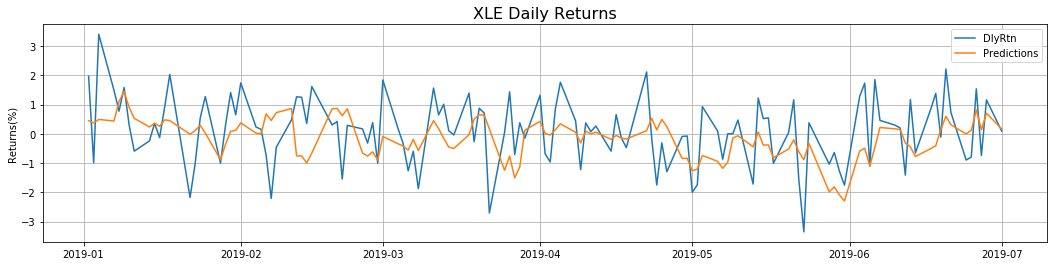

In [43]:
def daily_returns(pred_df, title):    
    plt.figure(figsize=(18,4))
    plt.title(title, fontsize=16)
    plt.plot(pred_df[['DlyRtn', 'Predictions']])
    plt.ylabel('Returns(%)')
    plt.legend(pred_df[['DlyRtn', 'Predictions']])
    plt.grid()
    plt.show()
daily_returns(xle_pred, 'XLE Daily Returns')

In [44]:
def monthly_df(pred_df, pred_column):
    predictions = month_preds(pred_df, 'Predictions', pred_column)
    actual_returns = month_preds(pred_df, 'DlyRtn', 'Actual Returns')
    new_df = pd.concat([predictions, actual_returns], axis=1)
    percent_df = (new_df -1)*100
    percent_df['Difference'] = abs(percent_df[pred_column] - percent_df['Actual Returns'])
    return percent_df

monthly_df(xle_pred, 'XLE_Pred')

,XLE_Pred,Actual Returns,Difference
2019-01-31,7.070179,11.211866,4.141687
2019-02-28,0.166228,2.304795,2.138567
2019-03-29,-5.174079,2.128102,7.302181
2019-04-30,0.006571,-0.015137,0.021708
2019-05-31,-17.586832,-11.102704,6.484128
2019-06-28,-1.769307,9.395154,11.164461
